# PHASE_5_CAPSTONE_PROJECT

# SIAMESE NEUTRAL NETWORKS (SNN) - IMAGE SIMILARITY

### Data source:

The data source comprises more than 44 thousand fashion images obtained from Kaggle.

Source link: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

### Target:

NITA, the fashion company, is excited to introduce a cutting-edge feature that allows customers to perform image-based searches. With this new capability, the website can identify product types, empowering users to explore the top 5 closely matched products, resulting in a captivating and personalized shopping experience.

### Siamese neutral network (SNN) introduction

Siamese Neural Networks, or SNNs, is one of the most popular neural network architectures that use this strategy and can predict multiple classes from very little data. This ability has made Siamese neural networks very popular in real-world applications in security, face recognition, signature verification, and more.

A Siamese network consists of two or more identical subnetworks: neural networks with the same architecture, configuration, and weights. Even during training, parameter updates happen simultaneously for both neural networks with the same weights.

The purpose of having identical subnetworks is to train the model based on a similarity function that measures how different the feature vectors of one image are from the other. Because of this architecture, the model can be trained without much data.

For instance, to perform image classification, the model will train by comparing a given image with all the images in the dataset and thus learn semantic similarity between each image pair. Based on this learned similarity function, the siamese network predicts multiple classes by taking a test sample and comparing it with an image from each class.

Source: https://www.projectpro.io/article/siamese-neural-networks/718

In [222]:
import pandas as pd
import numpy as np
import csv
import json
import glob
import os
import cv2
import shutil
import random
import pickle
import h5py
import hdf5storage
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from IPython.display import display
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import Reshape


from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from keras.models import load_model


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# a new layer that rescales/normalizes the activations after each layer.
# has a weak regularization effect. also allows 

from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D

import tensorflow as tf


from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [221]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=64,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=64,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=64,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


### Model 1: CNN as a basenetwork + 5% dataset + margin of 1 +batch_size 64

In this section, we will build up 1st Siamese neutral networks basing on the best CNN model architecture with utilizing contrastive loss to predict the Euclidean distance of image pairs. The shorter the distance indicates the higher similarity of image pairs.

#### Create positive and negative pairs.

In [208]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


#### Loss function

In [223]:
#margin = 1

def contrastive_loss(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


#### Define Euclidean distance function

In [19]:
def euclid_dis(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [7]:
def base_model(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(input)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    model = tf.keras.Model(inputs=input, outputs=x)
#     model = tf.keras.Model(inputs=input, outputs=output) #Same with above line
    return model

In [8]:
def create_siamese_model(base_model, input_shape):
    # Input for left and right image vectors
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Pass the left and right inputs through the base model
    left_output = base_model(left_input)
    right_output = base_model(right_input)

    # Calculate the Euclidean distance between the two outputs
    distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([left_output, right_output])

    # Create the Siamese model
    siamese_model = Model(inputs=[left_input, right_input], outputs=distance)
#     siamese_model = Model(inputs=[left_input, right_input], outputs=distance) # Same with above line

    return siamese_model

In [8]:
base_network = base_model((256,256,3))

In [9]:
siamese_model2 = create_siamese_model(base_network,(256,256,3))

In [10]:
siamese_model2.compile(loss=contrastive_loss,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

During the input calculation step, we will narrow the scope of the training and validation sets. Besides, the number of pairs trained each time will be determined by the batch size.

Due to computational limitations, I would try to train the model with 5% of the train data.

In [11]:
# Define the batch size and number of pairs per batch
batch_size = 64
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

The input above will be fit into the model.

In [12]:
history_siamese_model2 = siamese_model2.fit(
    custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
    steps_per_epoch=train_num_batches_per_epoch,
    validation_data=custom_data_generator(val_generator, num_classes, num_pairs_per_batch),
    validation_steps=val_num_batches_per_epoch,  
    epochs=20
)

Epoch 1/20
11/11 [==============================] - 1248s 114s/step - loss: 0.4795 - accuracy: 0.4995 - auc: 0.4963 - precision: 0.4860 - recall: 0.2759 - val_loss: 0.2954 - val_accuracy: 0.5143 - val_auc: 0.5059 - val_precision: 0.4973 - val_recall: 0.3770
Epoch 2/20
11/11 [==============================] - 1216s 111s/step - loss: 0.2750 - accuracy: 0.5042 - auc: 0.4964 - precision: 0.5127 - recall: 0.3887 - val_loss: 0.2760 - val_accuracy: 0.4936 - val_auc: 0.4937 - val_precision: 0.4800 - val_recall: 0.4191
Epoch 3/20
11/11 [==============================] - 1146s 105s/step - loss: 0.2670 - accuracy: 0.4999 - auc: 0.5004 - precision: 0.4975 - recall: 0.3520 - val_loss: 0.2711 - val_accuracy: 0.5235 - val_auc: 0.5155 - val_precision: 0.5413 - val_recall: 0.2141
Epoch 4/20
11/11 [==============================] - 1148s 104s/step - loss: 0.2674 - accuracy: 0.4964 - auc: 0.5046 - precision: 0.5002 - recall: 0.3990 - val_loss: 0.2725 - val_accuracy: 0.5038 - val_auc: 0.5030 - val_precisi

#### Save model and history

Save the model and its history.

In [209]:
# siamese_model2.save('siamese_model2_20epoch.h5')

In [210]:
# hdf5storage.savemat("history_siamese_model2_20epoch.h5", history_siamese_model2.history)

#### Load the model and history

In [235]:
siamese_model_loaded = load_model('siamese_model2_20epoch.h5', custom_objects={'contrastive_loss': contrastive_loss})

In [371]:
siamese_model_loaded.evaluate(
    custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
    steps=train_num_batches_per_epoch)

11/11 [==============================] - 209s 19s/step - loss: 0.2656 - accuracy: 0.4927 - auc: 0.4863 - precision: 0.4896 - recall: 0.4469


[0.26563766598701477,
 0.4927188754081726,
 0.4863257110118866,
 0.4896443784236908,
 0.4469413161277771]

In [372]:
siamese_model_loaded.evaluate(
    custom_data_generator(test_generator, num_classes, num_pairs_per_batch),
    steps=test_num_batches_per_epoch)

3/3 [==============================] - 56s 18s/step - loss: 0.2852 - accuracy: 0.5060 - auc: 0.4989 - precision: 0.5202 - recall: 0.2419


[0.285208135843277,
 0.5060241222381592,
 0.498872846364975,
 0.5201668739318848,
 0.24191461503505707]

In [373]:
siamese_model_loaded.evaluate(
    custom_data_generator(test_generator, num_classes, num_pairs_per_batch),
    steps=len(test_generator))

77/77 [==============================] - 1382s 18s/step - loss: 0.2879 - accuracy: 0.4998 - auc: 0.5002 - precision: 0.4996 - recall: 0.2057


[0.2879106104373932,
 0.4997716248035431,
 0.5002148747444153,
 0.4996301829814911,
 0.20566296577453613]

In [236]:
history_siamese_model_loaded= hdf5storage.loadmat("history_siamese_model2_20epoch.h5.mat",custom_objects={'contrastive_loss': contrastive_loss})

In [214]:
print(history_siamese_model_loaded.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


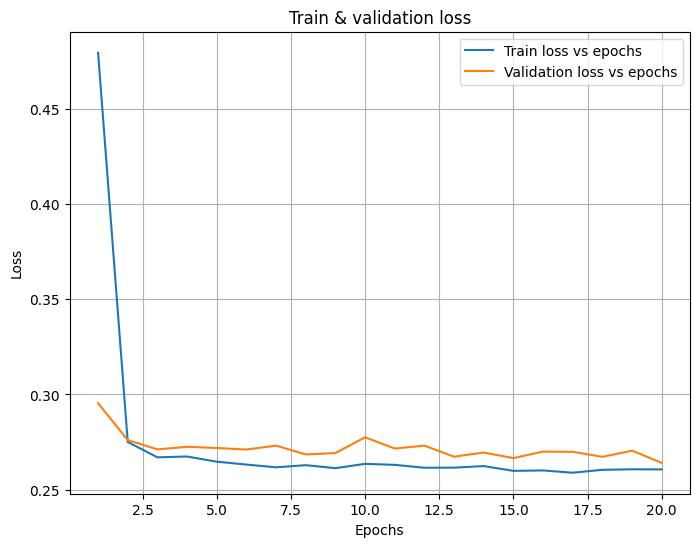

In [231]:
fig,ax=plt.subplots(figsize=(8,6))

siamese_loss_values = history_siamese_model_loaded['loss']
siamese_val_loss_values = history_siamese_model_loaded['val_loss']


epochs = range(1,len(siamese_loss_values)+1)

ax.plot(epochs,siamese_loss_values,label='Train loss vs epochs')
ax.plot(epochs,siamese_val_loss_values,label='Validation loss vs epochs')

ax.set_title('Train & validation loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Loss');

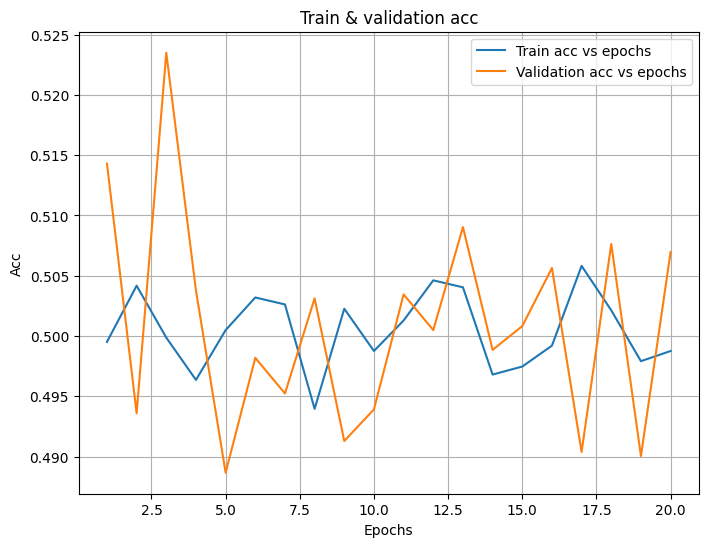

In [234]:
fig,ax=plt.subplots(figsize=(8,6))

siamese_acc_values = history_siamese_model_loaded['accuracy']
siamese_val_acc_values = history_siamese_model_loaded['val_accuracy']


epochs = range(1,len(siamese_acc_values)+1)

ax.plot(epochs,siamese_acc_values,label='Train acc vs epochs')
ax.plot(epochs,siamese_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

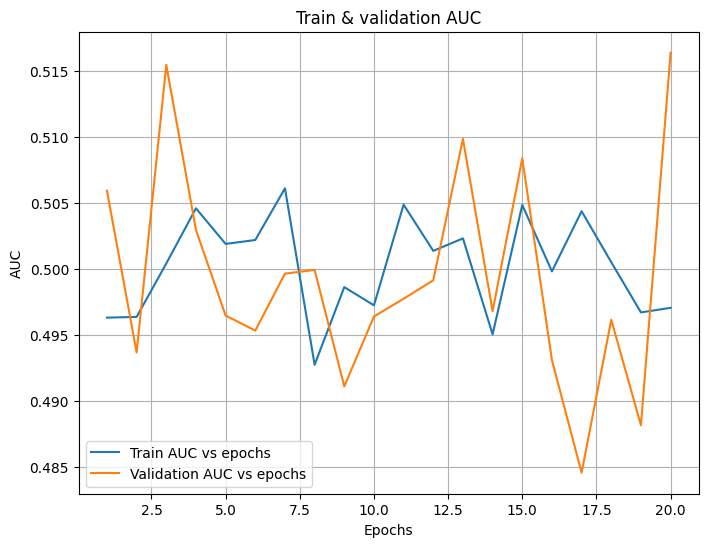

In [219]:
fig,ax=plt.subplots(figsize=(8,6))

siamese_AUC_values = history_siamese_model_loaded['auc']
siamese_val_AUC_values = history_siamese_model_loaded['val_auc']


epochs = range(1,len(siamese_AUC_values)+1)

ax.plot(epochs,siamese_AUC_values,label='Train AUC vs epochs')
ax.plot(epochs,siamese_val_AUC_values,label='Validation AUC vs epochs')

ax.set_title('Train & validation AUC')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('AUC');

The validation loss remains consistently low and stable, but the validation accuracy fluctuates around 50%. This model will serve as our baseline for further improvement in the subsequent steps.

In [239]:
# Predict on the test set
test_pairs, test_labels = create_siamese_pairs(test_generator, num_classes, len(test_generator))
siamese_model_predictions = siamese_model_loaded.predict([test_pairs[:, 0], test_pairs[:, 1]])

77/77 [==============================] - 49s 633ms/step


In [240]:
siamese_model_predictions.min()

0.047223035

In [241]:
siamese_model_predictions.max()

1.0218074

### Model 2: Base network ResNet50 + 5% of dataset + margin of 1 + batch_size 32

In the following, we will reduce the batch size to 32 and use Resnet50 as the base networks for Siamese model.

In [116]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator_batch32 = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_batch32 = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator_batch32 = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=32,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


In [117]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


In [118]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [119]:
def euclid_dis(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [120]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [121]:
# Function to create Resnet50 base model
def base_model_resnet50(input_shape):
    base_resnet50_model = ResNet50(include_top=False,weights = 'imagenet',input_shape=input_shape)
    for layers in base_resnet50_model.layers:
          layers.trainable = False
    return base_resnet50_model

In [122]:
# Function to build the siamese model
def build_siamese_model_resnet50(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [123]:
train_pair_gen = custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch)

In [124]:
batch_pairs, batch_labels = next(train_pair_gen)

In [125]:
len(batch_pairs[0])

256

In [126]:
len(batch_labels)

256

In [127]:
num_positive_pairs = num_classes * (batch_size // num_classes)
num_positive_pairs

30

In [128]:
num_negative_pairs = batch_size * (num_classes - 1)
num_negative_pairs

288

In [129]:
siamese_resnet50_model_batch32 = build_siamese_model_resnet50((256,256,3))

In [130]:
siamese_resnet50_model_batch32.compile(loss=contrastive_loss05,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [131]:
history_siamese_resnet50_model_batch32 = siamese_resnet50_model_batch32.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
)

Epoch 1/10
11/11 [==============================] - 257s 24s/step - loss: 1319.1847 - accuracy: 0.5060 - auc: 0.5069 - precision: 0.5168 - recall: 0.4616 - val_loss: 0.1217 - val_accuracy: 0.5117 - val_auc: 0.5027 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 2/10
11/11 [==============================] - 248s 23s/step - loss: 6.3627 - accuracy: 0.5110 - auc: 0.5090 - precision: 0.5244 - recall: 0.1919 - val_loss: 0.1311 - val_accuracy: 0.4753 - val_auc: 0.4986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 236s 22s/step - loss: 0.1282 - accuracy: 0.4863 - auc: 0.5003 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 53.1161 - val_accuracy: 0.4648 - val_auc: 0.5000 - val_precision: 0.4648 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 235s 22s/step - loss: 6.6040 - accuracy: 0.5213 - auc: 0.5114 - precision: 0.5156 - recall: 0.1935 - val_loss: 0.1145 - val_accuracy: 0.5417 - val_auc: 0.4988 -

Sadly, the validation accuracy has not improved a bit, still stuck at around 50%.

### Model 3: Base network ResNet50 + 5% of dataset + margin of 0.5 + batch_size 32 +  learning rate 0.0005

In this model, we will reduce margin from 1 to 0.5 and also drop learning rate from 0.001 to 0.0005 to try improve the stability of training model.

In [192]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator_batch32 = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_batch32 = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator_batch32 = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=32,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


In [193]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


In [194]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [195]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [196]:
siamese_resnet50_model_batch32_lr = build_siamese_model_resnet50((256,256,3))

In [197]:
siamese_resnet50_model_batch32_lr.compile(loss=contrastive_loss05,optimizer=opt,
                  metrics=['accuracy','AUC','Precision','Recall'])

In [198]:
history_siamese_resnet50_model_batch32_lr = siamese_resnet50_model_batch32_lr.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
) 

Epoch 1/10
11/11 [==============================] - 245s 23s/step - loss: 342.3020 - accuracy: 0.4904 - auc: 0.4923 - precision: 0.4805 - recall: 0.5367 - val_loss: 0.1371 - val_accuracy: 0.4492 - val_auc: 0.5015 - val_precision: 1.0000 - val_recall: 0.0024
Epoch 2/10
11/11 [==============================] - 240s 22s/step - loss: 1.0113 - accuracy: 0.5021 - auc: 0.4998 - precision: 0.4980 - recall: 0.1821 - val_loss: 0.1333 - val_accuracy: 0.4661 - val_auc: 0.5010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 240s 22s/step - loss: 1.4981 - accuracy: 0.4934 - auc: 0.4964 - precision: 0.4922 - recall: 0.1777 - val_loss: 4.4101 - val_accuracy: 0.4870 - val_auc: 0.5000 - val_precision: 0.4870 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 236s 22s/step - loss: 2.9182 - accuracy: 0.4996 - auc: 0.4970 - precision: 0.4896 - recall: 0.2699 - val_loss: 0.1206 - val_accuracy: 0.5169 - val_auc: 0.4987 - val_preci

Still, validation accuracy is around 50% while validation precision and recall are extremely small, which indicates that the model is too simple to train or having class imbalance.

### Model 4: Base network ResNet50 + 30% of dataset + margin of 0.5 + batch_size 32 +  learning rate 0.0005

In this model, we will increase the input data size to 30% more than the total train data.

In [200]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.3

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [201]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [202]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [203]:
siamese_resnet50_bat32_lr00005_30train = build_siamese_model_resnet50((256,256,3))

In [204]:
siamese_resnet50_bat32_lr00005_30train.compile(loss=contrastive_loss05,optimizer=opt,
                  metrics=['accuracy','AUC','Precision','Recall'])

In [205]:
history_siamese_resnet50_bat32_lr00005_30train = siamese_resnet50_bat32_lr00005_30train.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
) 

Epoch 1/10
69/69 [==============================] - 1669s 24s/step - loss: 42.8385 - accuracy: 0.5065 - auc: 0.5047 - precision: 0.5081 - recall: 0.2076 - val_loss: 0.1265 - val_accuracy: 0.4933 - val_auc: 0.5003 - val_precision: 1.0000 - val_recall: 3.3659e-04
Epoch 2/10
69/69 [==============================] - 1645s 24s/step - loss: 0.7555 - accuracy: 0.4956 - auc: 0.4981 - precision: 0.4792 - recall: 0.0415 - val_loss: 0.1268 - val_accuracy: 0.4924 - val_auc: 0.4997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
69/69 [==============================] - 1642s 24s/step - loss: 0.8866 - accuracy: 0.4972 - auc: 0.4998 - precision: 0.4961 - recall: 0.0143 - val_loss: 0.1273 - val_accuracy: 0.4899 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
69/69 [==============================] - 1664s 24s/step - loss: 0.1248 - accuracy: 0.5003 - auc: 0.4999 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1253 - val_accuracy: 0.4982 - val_

Still the test accuracy stuck at around 50%, with too small precision and recall rate. While the training time per epoch is long, if we continue with all train set, the current computer cannot handle it.

###  Model 5: Base network ResNet50 + 5% of dataset + margin of 0.1 + batch_size 32 

In [142]:
def contrastive_loss01(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [143]:
siamese_resnet50_model_batch32_loss01 = build_siamese_model_resnet50((256,256,3))

In [144]:
siamese_resnet50_model_batch32_loss01.compile(loss=contrastive_loss01,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [145]:
history_siamese_resnet50_batch32_loss01 = siamese_resnet50_model_batch32_loss01.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
)

Epoch 1/10
11/11 [==============================] - 241s 22s/step - loss: 1245.0192 - accuracy: 0.5027 - auc: 0.5036 - precision: 0.5083 - recall: 0.3670 - val_loss: 0.0049 - val_accuracy: 0.5091 - val_auc: 0.4963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 230s 21s/step - loss: 0.0049 - accuracy: 0.5089 - auc: 0.5008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.4781 - val_auc: 0.5023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 232s 22s/step - loss: 7.2944 - accuracy: 0.4764 - auc: 0.4913 - precision: 0.5000 - recall: 0.1737 - val_loss: 62.8387 - val_accuracy: 0.4948 - val_auc: 0.5000 - val_precision: 0.4948 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 230s 21s/step - loss: 10.6421 - accuracy: 0.5011 - auc: 0.5002 - precision: 0.4980 - recall: 0.1818 - val_loss: 84.2778 - val_accuracy: 0.4848 - val_auc

The result is still not better.

###  Model 6: Base network ResNet50 + 5% of dataset + margin of 0.1 + batch_size 32 

In [150]:
# Function to build the siamese model
def build_siamese_model_resnet50_reg(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=L2(0.005))(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=L2(0.005))(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [151]:
siamese_resnet50_model_batch32_reg = build_siamese_model_resnet50_reg((256,256,3))

In [152]:
siamese_resnet50_model_batch32_reg.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [153]:
history_siamese_resnet50_model_batch32_reg = siamese_resnet50_model_batch32_reg.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10)

Epoch 1/10
11/11 [==============================] - 247s 23s/step - loss: 1108.1035 - accuracy: 0.4963 - auc: 0.4980 - precision: 0.5020 - recall: 0.6309 - val_loss: 0.8522 - val_accuracy: 0.4792 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 233s 22s/step - loss: 0.8347 - accuracy: 0.4993 - auc: 0.4963 - precision: 0.4724 - recall: 0.0860 - val_loss: 0.7905 - val_accuracy: 0.4688 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 232s 22s/step - loss: 11.9101 - accuracy: 0.5025 - auc: 0.5089 - precision: 0.5156 - recall: 0.1870 - val_loss: 0.7971 - val_accuracy: 0.4818 - val_auc: 0.5028 - val_precision: 0.3077 - val_recall: 0.0102
Epoch 4/10
11/11 [==============================] - 228s 21s/step - loss: 3.4254 - accuracy: 0.5030 - auc: 0.4945 - precision: 0.4961 - recall: 0.0909 - val_loss: 0.7856 - val_accuracy: 0.5195 - val_auc: 0.5000 -

The result stays the same

### Model 7: Base network ResNet50 + 5% of dataset + margin of 1.5 + batch_size 32 

In this model, we will increase the margin to 1.5

In [185]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [186]:
def contrastive_loss15(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 1.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [187]:
# Function to build the siamese model
def build_siamese_model_resnet50_reg(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [188]:
siamese_resnet50_model_batch32_loss15 = build_siamese_model_resnet50((256,256,3))

In [189]:
siamese_resnet50_model_batch32_loss15.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [190]:
history_siamese_resnet50_model_batch32_loss15 = siamese_resnet50_model_batch32_loss15.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10)

Epoch 1/10
11/11 [==============================] - 408s 37s/step - loss: 1236.2583 - accuracy: 0.4984 - auc: 0.4954 - precision: 0.5026 - recall: 0.5486 - val_loss: 0.0438 - val_accuracy: 0.5117 - val_auc: 0.5040 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 2/10
11/11 [==============================] - 365s 33s/step - loss: 0.0438 - accuracy: 0.5135 - auc: 0.4979 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0470 - val_accuracy: 0.4768 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 258s 24s/step - loss: 7.1681 - accuracy: 0.5110 - auc: 0.5085 - precision: 0.5156 - recall: 0.1895 - val_loss: 0.0446 - val_accuracy: 0.5026 - val_auc: 0.5013 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 4/10
11/11 [==============================] - 248s 23s/step - loss: 11.5144 - accuracy: 0.5023 - auc: 0.5049 - precision: 0.5176 - recall: 0.1868 - val_loss: 35.8667 - val_accuracy: 0.4993 - val_auc: 0.5000 

There is no change in the result.

### Conclusion

As we have made different attempts to improve the model but the result has not been improved. Due to the limitation of time, we will utilize our first model for deployment.